""" Explore Population files and re-allocate population to grid.
It can also be used to visualize static grids and create dummy emissions/mortality files
 @author: lucarojasmendoza last modified: 2024-02-12 """

In [123]:
#import packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from shapely.geometry import Point
from datetime import datetime
import os
from time import time
from cmcrameri import cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import random as random
import xarray as xr

# Import supporting functions 
%run sgrids.py

# Visualize Demographics Data

In [10]:
pop_gdf= gpd.read_file('Pavitra_IITB/Population/GPW_Ind_2020_1km_LLC.shp')

In [17]:
pop_gdf.head(20)

,TotalPop,x,y,geometry
0,4.323504,74.685206,37.075000,"POLYGON ((-569856.557 4292467.526, -569856.557..."
1,2.545646,74.693541,37.075000,"POLYGON ((-568961.393 4292467.526, -568961.393..."
2,0.293721,74.701877,37.075000,"POLYGON ((-568066.228 4292467.526, -568066.228..."
3,0.579641,74.710213,37.075000,"POLYGON ((-567171.064 4292467.526, -567171.064..."
4,4.323979,74.668534,37.066664,"POLYGON ((-571646.886 4291345.623, -571646.886..."
5,4.323979,74.676870,37.066664,"POLYGON ((-570751.722 4291345.623, -570751.722..."
6,4.323979,74.685206,37.066664,"POLYGON ((-569856.557 4291345.623, -569856.557..."
7,3.891887,74.693541,37.066664,"POLYGON ((-568961.393 4291345.623, -568961.393..."
8,0.615576,74.701877,37.066664,"POLYGON ((-568066.228 4291345.623, -568066.228..."
9,0.452210,74.710213,37.066664,"POLYGON ((-567171.064 4291345.623, -567171.064..."


In [25]:
pop_gdf.shape

(4131898, 4)

<Axes: >

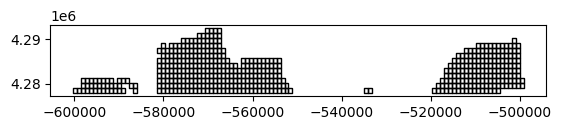

In [41]:
pop_gdf.iloc[0:500].plot(facecolor='none',edgecolor='black')

<Axes: >

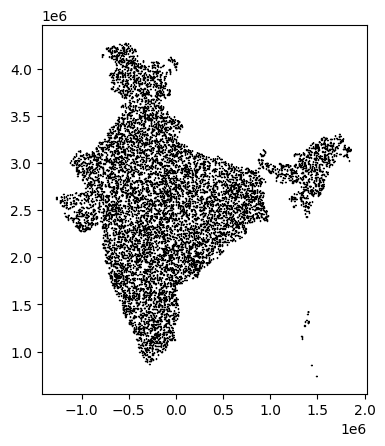

In [50]:
random.seed(42)  # Setting seed for reproducibility
random_indices = random.sample(range(len(pop_gdf)), 50000)
random_sample = pop_gdf.iloc[random_indices]
random_sample.plot(facecolor='none', edgecolor='black')

In [23]:
pop_gdf['TotalPop'].sum()

1411594183.0698647

In [28]:
pop_gdf.crs

<Projected CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_unk ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: D_unknown
- Ellipsoid: Normal_Sphere_r_6370997
- Prime Meridian: Greenwich

## Static grid resolution algorithm (https://inmap.run/docs/variable_grid/)
The static algorithm chooses the size of all grid cells before the simulation starts, and does not change the size of any grid cells while the simulation is running. Grid cell sizes are chosen based on the number of people in the grid cell, where any grid cell with more people than specified by the VarGrid.PopThreshold configuration variable or containing any region with population density greater than specified by the VarGrid.PopDensityThreshold configuration variable (in units of people per the square of the native length units of the grid [e.g., meters or degrees]) is split into smaller grid cells. This algorithm is applied to all grid cells within the number of vertical layers from ground-level specified by the VarGrid.HiResLayers configuration variable. All grid cells above that layer are kept at the lowest possible resolution.

To choose this algorithm, users can set the static configuration variable to true. The static grid must either be created ahead of time using the inmap grid command or at the beginning of the simulation by setting the creategrid configuration variable to true.

In [51]:
source_crs="+proj=merc +units=m +a=6370000.0 +b=6370000.0 +lon_0=80.0 +lat_ts=15.0 +no_defs"
pop_gdf.crs=source_crs
dems = pop_gdf.copy()

In [56]:
#Map of India and SAARC
india_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/INDIA_BOUNDARY.shp')
saarcwi_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/SAARCWIC.shp')
india_gdf= india_gdf.to_crs(source_crs)
saarcwi_gdf=saarcwi_gdf.to_crs(source_crs)

In [119]:
#Example 27 km Grid Cell Only (Does not match grid cells of WRF-CHEM Domain)
VariableGridXo=-2298000.274
VariableGridYo= -202000.500
VariableGridDxy= 27000
Xnests=[166]
Ynests=[180]
#Threshold values for TotalPop and density
totalpop_threshold = 100000
density_threshold = 0.01

In [ ]:
#Visualize demographics 
visualize_data(dems, source_crs, VariableGridXo, VariableGridYo, VariableGridDxy, Xnests, Ynests)

In [59]:
gdf=sgrids(dems, source_crs,
           VariableGridXo, VariableGridYo, VariableGridDxy, 
           Xnests, Ynests,
           totalpop_threshold,density_threshold, plots=False)

,Number of grids
27000.0,29880
totals,29880


Execution time: 190.7868 seconds


In [62]:
gdf['TotalPop'].sum()

1411594183.0698655

In [80]:
gdf

,geometry,index,TotalPop,density,area,length
0,"POLYGON ((-2271000.274 4630999.500, -2271000.2...",0,0.0,0.0,729000000.0,27000.0
1,"POLYGON ((-2271000.274 4603999.500, -2271000.2...",1,0.0,0.0,729000000.0,27000.0
2,"POLYGON ((-2271000.274 4576999.500, -2271000.2...",2,0.0,0.0,729000000.0,27000.0
3,"POLYGON ((-2271000.274 4549999.500, -2271000.2...",3,0.0,0.0,729000000.0,27000.0
4,"POLYGON ((-2271000.274 4522999.500, -2271000.2...",4,0.0,0.0,729000000.0,27000.0
...,...,...,...,...,...,...
29875,"POLYGON ((2183999.726 -94000.500, 2183999.726 ...",29875,0.0,0.0,729000000.0,27000.0
29876,"POLYGON ((2183999.726 -121000.500, 2183999.726...",29876,0.0,0.0,729000000.0,27000.0
29877,"POLYGON ((2183999.726 -148000.500, 2183999.726...",29877,0.0,0.0,729000000.0,27000.0
29878,"POLYGON ((2183999.726 -175000.500, 2183999.726...",29878,0.0,0.0,729000000.0,27000.0


In [92]:
gdf['density'].max()

0.09747518942736771

<Axes: title={'center': 'Population Density using 27Km grids in (# / m²)'}>

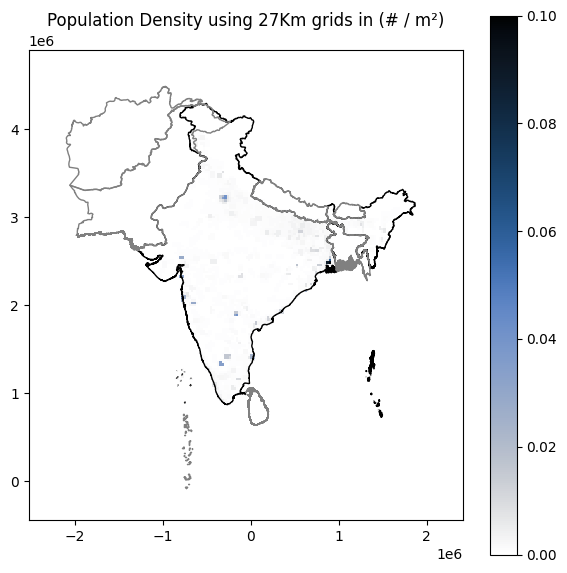

In [101]:
# Plot the population redistribution
fig, ax = plt.subplots(figsize=(7, 7))
gdf.plot(column='density', cmap=cm.oslo_r, legend=True, ax=ax, vmin=0, vmax=0.1)
plt.title('Population Density using 27Km grids in (# / m\u00B2)')

# Plot the map of India on the same plot
india_gdf.plot(ax=ax, color='none', edgecolor='black')
saarcwi_gdf.plot(ax=plt.gca(), color='none', edgecolor='gray')


In [106]:
#Example with IITbombay proposal
VariableGridXo=-2298000.274
VariableGridYo= -202000.500
VariableGridDxy= 64000
Xnests=[70,2,2,2,2,2]
Ynests=[76,2,2,2,2,2]
#Threshold values for TotalPop and density
totalpop_threshold = 100000
density_threshold = 0.05

In [107]:
gdf=sgrids(dems, source_crs,
           VariableGridXo, VariableGridYo, VariableGridDxy,
           Xnests, Ynests,
           totalpop_threshold,density_threshold, plots=False)

,Number of grids
64000.0,5320
totals,5320


,Number of grids
64000.0,4457
32000.0,3452
totals,7909


KeyboardInterrupt: 

In [ ]:
#Save file 
gdf.to_file('Pavitra_IITB/2_2_2_2_2_2_100000_01.shp')

# Visualize grid across different administrative Boundaries

In [116]:
#Modify for india states or map of other communities of interest
india_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/INDIA_BOUNDARY.shp').to_crs(source_crs)
saarcwi_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/SAARCWIC.shp').to_crs(source_crs)
state_gdf=gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/India_State_Boundary.shp').to_crs(source_crs)
district_gdf=gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/India_District_Merge.shp').to_crs(source_crs)
city_gdf=gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/cities.shp').to_crs(source_crs)

india_gdf = india_gdf[['OBJECTID', 'geometry']]
state_gdf = state_gdf[['Name', 'geometry']]
district_gdf = district_gdf[['dtname','stname','geometry']]
city_gdf = city_gdf[['Name','geometry']]
saarcwi_gdf = saarcwi_gdf[['NAME_0','geometry']]

In [110]:
sgrids_table(gdf)

,Number of grids
27000.0,29880
totals,29880


In [118]:
np.sum(gdf['TotalPop']*gdf['length'])/(gdf['TotalPop'].sum())

27000.0

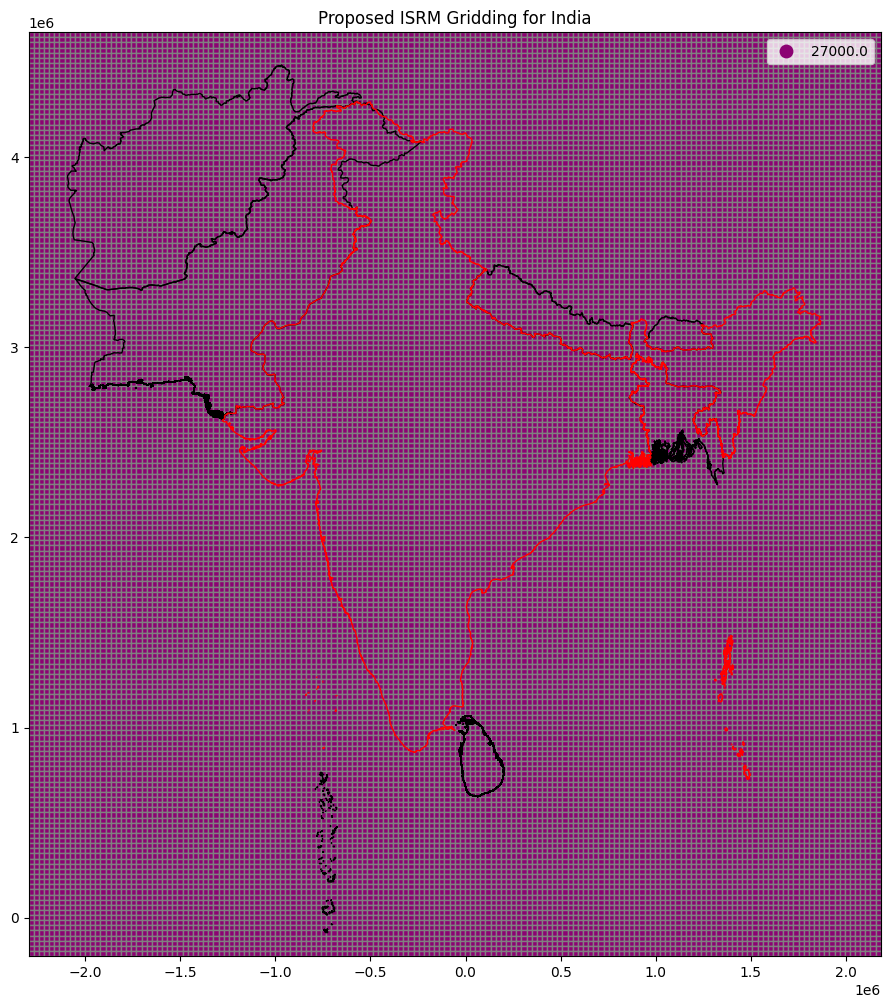

In [124]:
plot_with_scalebar(gdf, saarcwi_gdf, india_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Proposed ISRM Gridding for India')

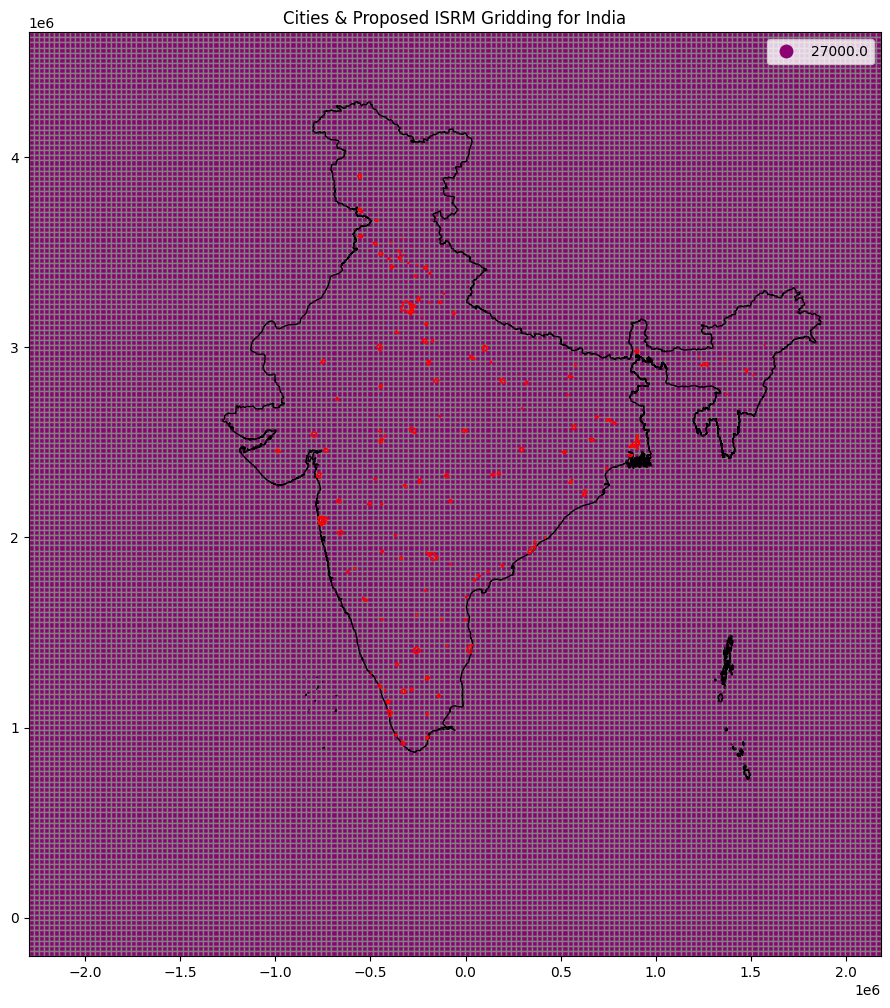

In [129]:
plot_with_scalebar(gdf, india_gdf, city_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Cities & Proposed ISRM Gridding for India')

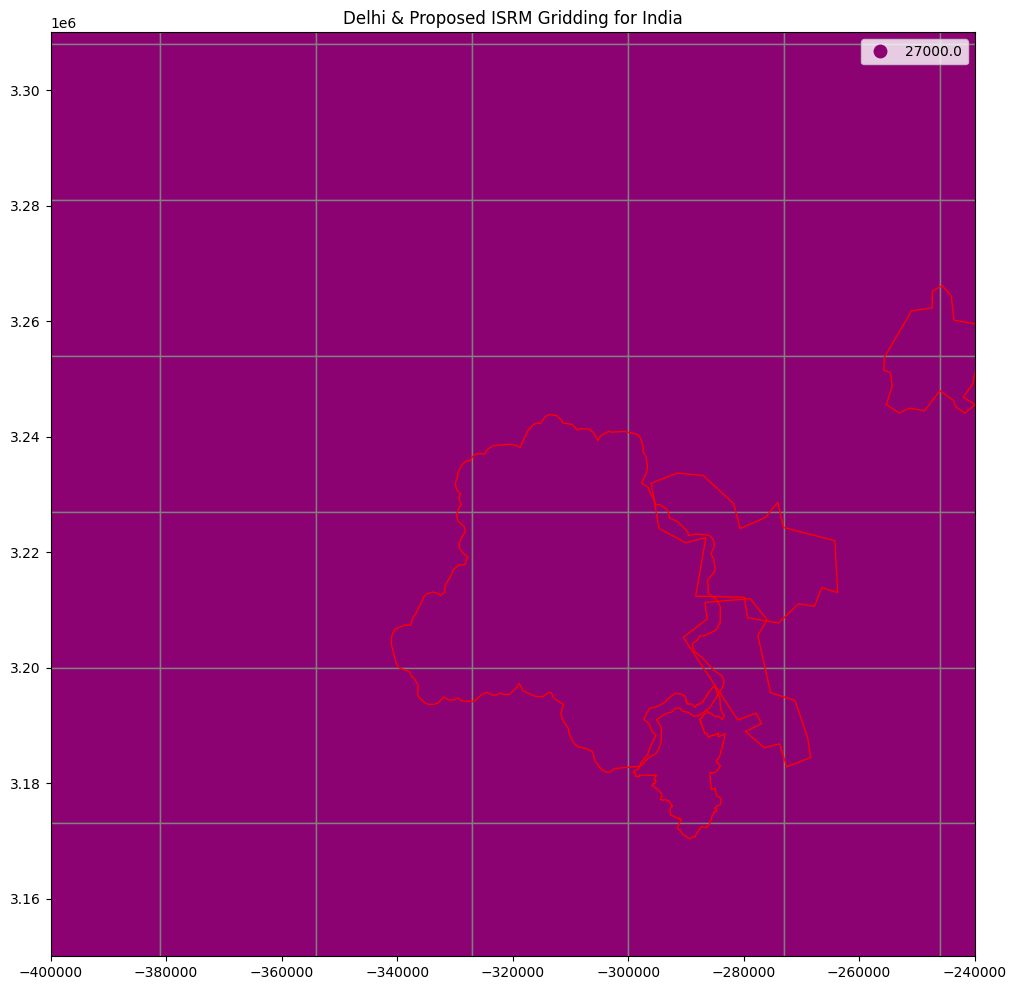

In [135]:
plot_with_scalebar(gdf, india_gdf, city_gdf, -400000,3150000,160000, 1,
                       y=1, figsize=(12, 12), target_crs=source_crs, title='Delhi & Proposed ISRM Gridding for India')

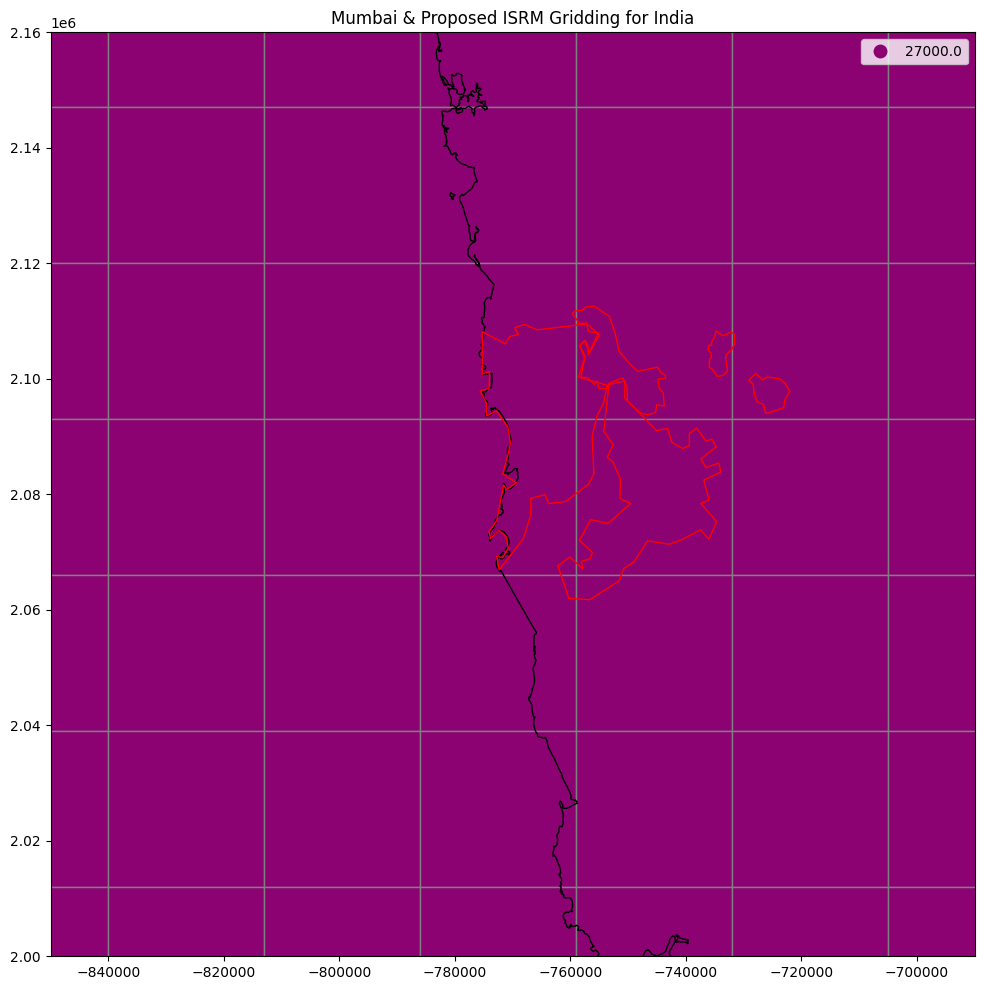

In [134]:
plot_with_scalebar(gdf, india_gdf, city_gdf, -850000,2000000,160000, 1,
                       y=1, figsize=(12, 12), target_crs=source_crs, title='Mumbai & Proposed ISRM Gridding for India')

In [136]:
summary_table=create_summary_table(gdf, city_gdf,index="Name")
desired_cities = ["Delhi", "Mumbai", "Bengaluru", "chennai", "Hyderabad", "Kolkata", "Ahmedabad", "Pune"]
summary_table[summary_table['Name'].isin(desired_cities)]

,Name,PopAveLengthScale,27000.0,Total Cells
1,Ahmedabad,27000.0,3,3
16,Bengaluru,27000.0,4,4
26,Delhi,27000.0,9,9
43,Hyderabad,27000.0,6,6
60,Kolkata,27000.0,7,7
70,Mumbai,27000.0,4,4
86,Pune,27000.0,2,2
113,chennai,27000.0,6,6


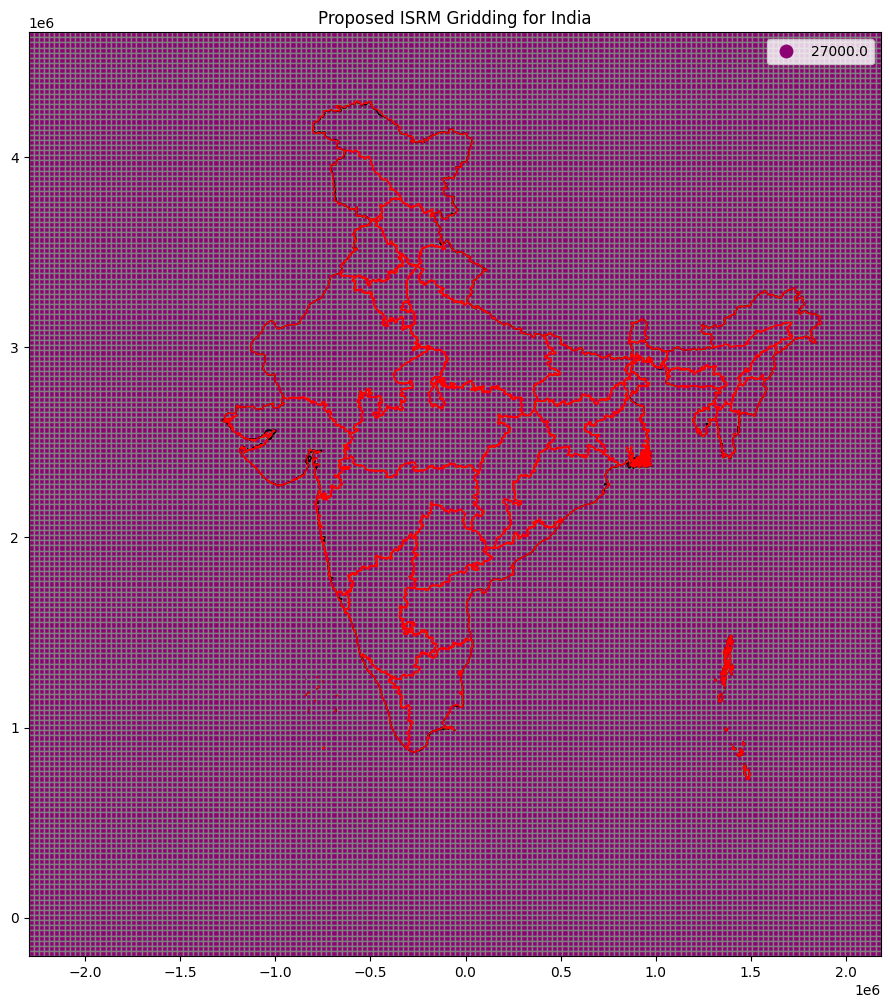

In [138]:
plot_with_scalebar(gdf, india_gdf, state_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Proposed ISRM Gridding for India')

In [100]:
state_gdf

,Name,geometry
0,West Bengal,"MULTIPOLYGON (((861111.851 2373444.037, 861142..."
1,Andaman & Nicobar,"MULTIPOLYGON (((1385453.502 1398355.265, 13854..."
2,Chandigarh,"POLYGON ((-346617.905 3478733.897, -346560.232..."
3,Daman and Diu and Dadra and Nagar Haveli,"MULTIPOLYGON (((-755655.481 2230790.517, -7556..."
4,Delhi,"POLYGON ((-310794.055 3240517.664, -310711.437..."
5,Haryana,"POLYGON ((-367780.461 3392335.994, -367652.299..."
6,Jharkhand,"POLYGON ((826480.946 2675046.654, 826494.000 2..."
7,Karnataka,"MULTIPOLYGON (((-286480.012 2016584.946, -2864..."
8,Kerala,"POLYGON ((-538131.205 1385668.182, -538070.859..."
9,Lakshadweep,"MULTIPOLYGON (((-743106.296 897341.029, -74310..."


In [139]:
create_summary_table(gdf, state_gdf[state_gdf['Name']=='Delhi'],index="Name")

,Name,PopAveLengthScale,27000.0,Total Cells
0,Delhi,27000.0,9,9


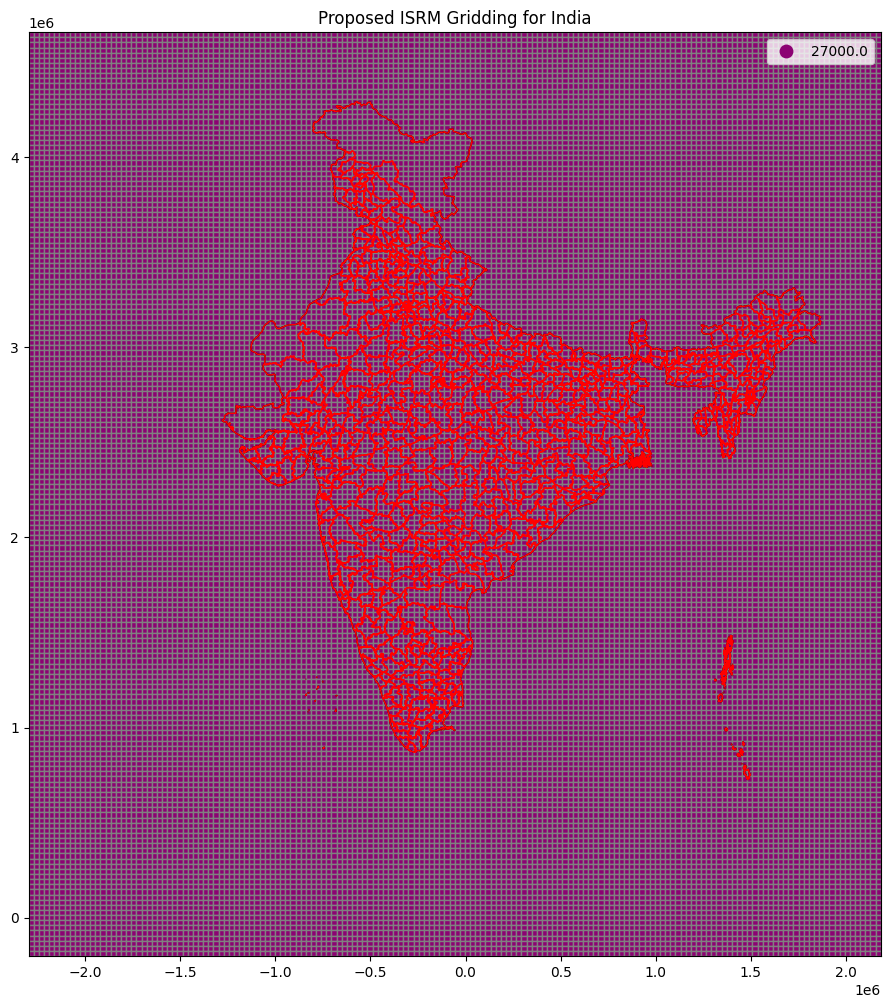

In [141]:
plot_with_scalebar(gdf, india_gdf, district_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Proposed ISRM Gridding for India')

In [142]:
create_summary_table(gdf, district_gdf[district_gdf['dtname']=='Kupwara'],index="dtname")

,dtname,PopAveLengthScale,27000.0,Total Cells
0,Kupwara,27000.0,13,13


# Create Dummy Emission file

In [56]:
# Could define points Mannually
# Define the list of points
points = [
    (77.1025, 28.7041),
    (72.8777, 19.0760)]


# Create a list of Point geometries
geometries = [Point(x, y) for x, y in points]

# Create a GeoPandas DataFrame
gdf = gpd.GeoDataFrame(geometry=geometries)

# create a new dataframe with only the geometry column
Emissions = gdf[['geometry']].copy()

# add the new columns to the Emissions dataframe with default values
cols = {'VOC': 1, 'NOx': 1, 'NH3': 1, 'SOx': 1, 'PM2_5': 1, 'height': 0, 'diam': 0, 'temp': 0, 'velocity': 0}
Emissions = Emissions.assign(**cols)

# Convert polygon geometries to point geometries at the center of the polygons
Emissions['geometry'] = Emissions['geometry'].centroid

# Reorder the columns and move the geometry column to the last
Emissions = Emissions[['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5', 'height', 'diam', 'temp', 'velocity', 'geometry']]

Emissions.crs = 'EPSG:4326' 


In [8]:
#Could also read grid of interest
gdf=gpd.read_file('.....')

# create a new dataframe with only the geometry column
Emissions_2 = gdf[['geometry']].copy()

# add the new columns to the Emissions dataframe with default values
cols = {'VOC': 10, 'NOx': 10, 'NH3': 10, 'SOx': 10, 'PM2_5': 10, 'height': 0, 'diam': 0, 'temp': 0, 'velocity': 0}
Emissions_2 = Emissions_2.assign(**cols)

# Convert polygon geometries to point geometries at the center of the polygons
Emissions_2['geometry'] = Emissions_2['geometry'].centroid

# Reorder the columns and move the geometry column to the last
Emissions_2 = Emissions_2[['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5', 'height', 'diam', 'temp', 'velocity', 'geometry']]
